In [3]:
#pip install -r requirements.txt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-v0_8-bright')

import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from tqdm import tqdm

import tasks
import models
from helpers import *

In [2]:
#Alpha
model_name = "alpha"
task_name = "TICT"
model, task, parameters = load_model(model_name, task_name)

In [3]:
n_check = 30
n_epochs = 200 * 5 + 1
d1_max = 90
d2_max = 95
batch_size = parameters["batch_size"]
learning_rate = parameters["learning_rate"]
hidden_size = parameters["hidden_size"]

## Warm up


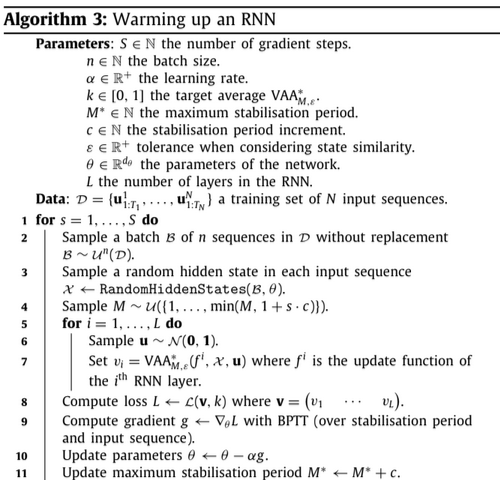

In [ ]:
def warm_up(model):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  c = 10
  M_star = 200
  k = torch.tensor(0.95)
  epsilon = 1e-3

  n_epochs_warmup = 100
  n_hidden_states = 32
  n_batch = int(n_hidden_states / 2)
  for s in tqdm(range(n_epochs_warmup)):
    inputs, labels, starts, ends, _, _  = task.get_random_trials(batch_size)
    data, targets = task.get_data(inputs, labels)
    loss = 0

    # Sample X
    sampled_states = torch.zeros((n_hidden_states, parameters["hidden_size"]))
    for b in range(n_batch):
      _, hidden = model(data, ends, b)
      t = np.random.randint(ends[0, b], size = 2)
      sampled_states[b, :] = hidden[0, t[0], :]
      sampled_states[b + n_batch, :] = hidden[0, t[1], :]

    # Sample M
    M = np.random.choice(np.arange(1, min(M_star, 2 + s * c)))

    # Get VAA*
    f_M = torch.zeros(sampled_states.shape)
    for n in range(n_hidden_states):
      f_M[n, :] = model.simulate(sampled_states[n, :], M)

    v = VAA_star(f_M, epsilon)

    # Loss and gradient step
    loss = criterion(v, k)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

model_name = "Alpha_TICT_warmup2.txt"

In [ ]:
warm_up(model)

100%|██████████| 100/100 [07:40<00:00,  4.60s/it]


## Training

In [ ]:
def train(model, save = False):
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_list = np.array([])
    produced_int = np.array([])
    correct_decision = np.array([])
    min_loss = 1e5

    for i in tqdm(range(1, n_epochs)):
        if i%n_check == 0:
            loss_list = np.append(loss_list, loss.detach().numpy())
            d1, d2 = check_accuracy(model)
            produced_int = np.append(produced_int, d1)
            correct_decision = np.append(correct_decision, d2)
            print(f" loss: {int(loss)} produced intervals: {d1:.2f}%; " \
                f"correct decisions: {d2:.2f}%")
            if save and int(loss) < min_loss:
                min_loss = int(loss)
                torch.save(model.state_dict(), model_name)
                if d1 > d1_max and d2 > d2_max:
                    print("success")
                    break

        inputs, labels, starts, ends, _, _  = task.get_random_trials(batch_size)
        data, targets = task.get_data(inputs, labels)
        loss = 0

        # forward
        for b in range(batch_size):
            scores, _ = model(data, ends, b)
            scores[0, :int(starts[0, b] - 1), :] *= 0
            loss += criterion(scores[0, :, :], targets[b, :int(ends[0, b]), :])

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent update step
        optimizer.step()

    return loss_list, produced_int, correct_decision

def check_accuracy(model):
    num_correct1 = 0
    num_correct2 = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():
        for i in range(int(n_check / 5)):
            inputs, labels, starts, ends, Ts, obj = task.get_random_trials(batch_size)
            T5s = Ts[4, :]
            data, targets = task.get_data(inputs, labels)

            scores = torch.zeros(targets.shape)
            # forward
            for b in range(batch_size):
                scores1, _ = model(data, ends, b)
                scores1[0, :int(starts[0, b] - 1), :] *= 0
                scores[b, :int(ends[0, b]) , :] = scores1

            for b in range(batch_size):
                num_samples += 1
                ti = np.argmax(labels[b, :, int(obj[0,b])] > 0.5)

                if check_produced(scores, T5s, b, ti):
                    num_correct1 += 1
                    if torch.max(scores[b, ti:ti+15, int(obj[0, b])]) > 0.5:
                        num_correct2 += 1

    model.train()
    try:
        return num_correct1/num_samples*100, num_correct2/num_correct1*100
    except:
        return num_correct1/num_samples*100, 0


loss_list, produced_int, correct_decision = train(model, save=False)

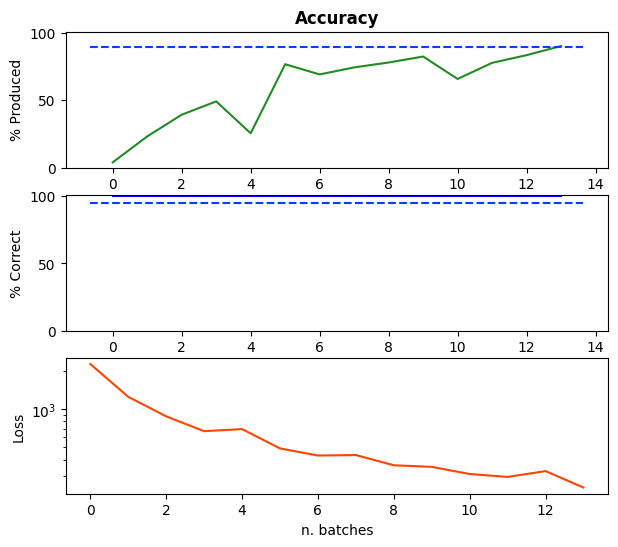

In [ ]:
plt.figure(figsize=(7,6))

plt.subplot(311)
plt.title("Accuracy", weight="bold")
plt.plot(produced_int, color="forestgreen")
axes = plt.gca()
xi, xs = axes.get_xlim()
plt.hlines(d1_max, xi, xs, linestyles="dashed")
plt.ylabel("% Produced")
plt.ylim([0, 101])

plt.subplot(312)
plt.plot(correct_decision, color="blue")
plt.hlines(d2_max, xi, xs, linestyles="dashed")
plt.ylim([0, 101])
plt.ylabel("% Correct")

plt.subplot(313)
plt.plot(loss_list, color="orangered")
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("n. batches")
plt.show()

## Testing

In [4]:
inputs, labels, starts, ends, Ts, obj = task.get_random_trials(batch_size)
T2s = Ts[1, :]
T3s = Ts[2, :]
data, targets = task.get_data(inputs, labels)

with torch.no_grad():
    scores = torch.zeros(targets.shape)
    hidden = torch.zeros(batch_size, task.lentv, hidden_size)
    for b in range(batch_size):
        scores1, hidden1 = model(data, ends, b)
        hidden[b, :, :] = hidden1
        scores1[0, :int(starts[0, b] - 1), :] *= 0
        scores[b, :int(ends[0, b]), :] = scores1

n = 1

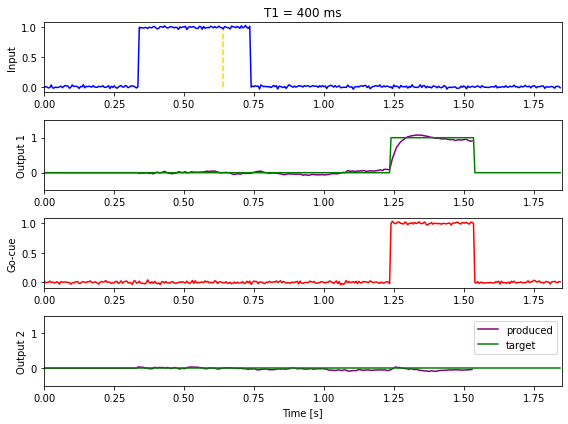

In [5]:
n += 1
title = "T1 = " + str(int(T2s[n] * task.step * 1e3)) + " ms"
task.plot_trial(scores, inputs, labels, starts, ends, n, title)

## Export

In [ ]:
# Create a file with the hidden activity of 400 trials (Hs) and the 
# information of those trials (Ts).

batch_size = 400

with torch.no_grad():
    inputs, labels, starts, ends, Ts, obj = get_random_trials()
    data, targets = get_data(inputs, labels)

    scores = torch.zeros(targets.shape)
    hiddens = torch.zeros(batch_size, len(tv), hidden_size)
    for b in range(batch_size):
        scores1, hidden1 = model(data, ends, b)
        hiddens[b, :, :] = hidden1
        scores1[0, :int(starts[0,b]-1), 0] *= 0
        scores[b, :int(ends[0,b]), :] = scores1

# Produce neu file
Hs = hiddens.detach().numpy() # e , t, neu
Hs = Hs.transpose(2,0,1).reshape(-1, len(tv)) # neu, e, t
np.savetxt("IC_neu_T4.txt", Hs)

# Produce info file
np.savetxt("IC_info_T4.txt", Ts)

In [ ]:
# Save the model

%cd saved_models/
torch.save(model.state_dict(), model_name)
%cd ..